__Purpose:__ Run FedAvg but with different hyperparameters.  Mainly:
1. C (GLOBAL): Fraction of clients used in training
1. local_round_thresh (LOCAL): probably should lower since local cost seems to reach zero super early... and also only advances one update?
 - Had very little effect... not what I had hoped.  Why not?
1. smoothbatch (SHARED)
1. PCA_comps (SHARED)
1. num_steps (SHARED)

## Client

def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=1, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', normalize_dec=False, normalize_EMG=True, track_cost_components=True, track_lr_comps=True, use_real_hess=True, gradient_clipping=False, log_decs=True, clipping_threshold=100, tol=1e-10, adaptive=True, eta=1, track_gradient=True, num_steps=1, input_eta=False, safe_lr_factor=False, mix_in_num_steps=False, mix_mixed_SB=False, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=50, condition_number=1, verbose=False):

## Server

def __init__(self, ID, D0, method, all_clients, smoothbatch=1, C=0.1, normalize_dec=True, current_round=0, PCA_comps=7, verbose=False, num_steps=10)

Server and client share smoothbatch, normalize_dec (THIS IS STILL TRUE BY DEFAULT ON SERVER!!!!), PCA_comps, and num_steps (THEY ARE SET TO DIFFERENT DEFAULTS!!!)

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [6]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)
big_loop_iters = 1000


# Federated Learning, FedAvg, 1 Scipy Step
> 1000 Iterations <br>
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

# Decoder Normalization
> Should I also break up the server dec normalization and test the effects of when you normalize (eg normalizing each client before aggregation vs just normalizing the aggregated vals)?  What do the differences imply?
## Interesting Performance Difference When Turn Off All Dec Normalization
> Global and local models converge together. Is this better performance?

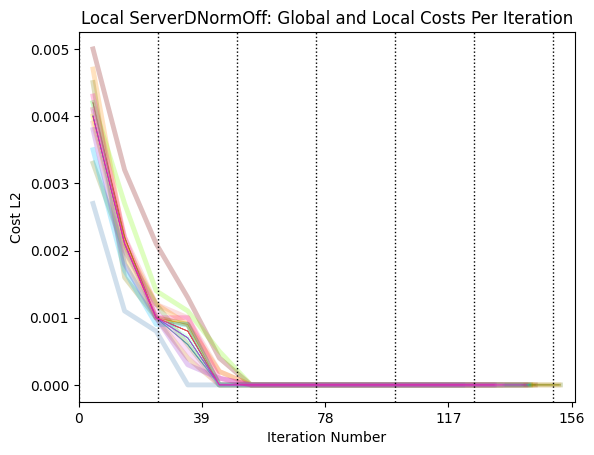

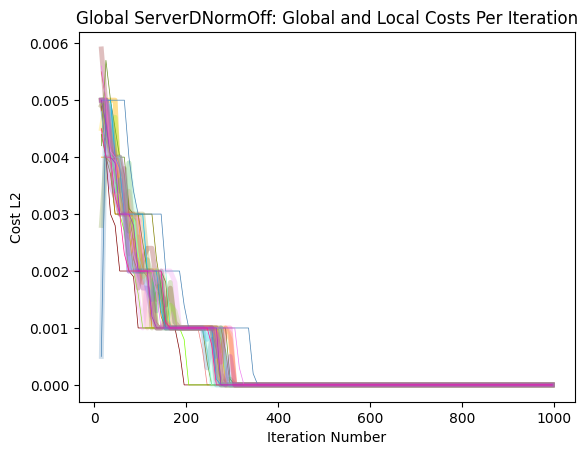

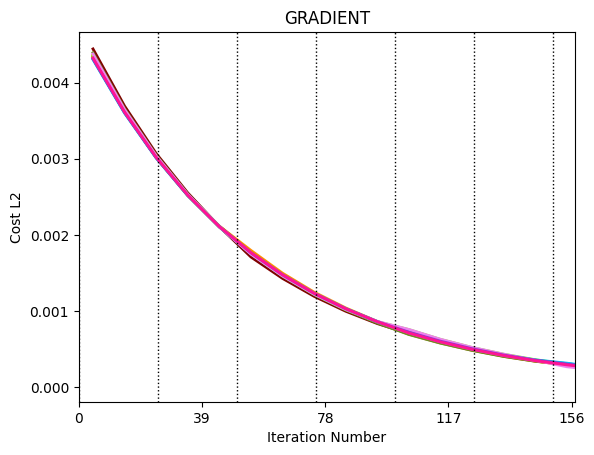

In [7]:
user_c0_1ScipyStep_serverDNormOff = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model_1scipystep_serverDNormOff = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_serverDNormOff, normalize_dec=False)

for i in range(big_loop_iters):
    global_model_1scipystep_serverDNormOff.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_serverDNormOff, 'local', custom_title='Local ServerDNormOff: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_1scipystep_serverDNormOff, 'global', show_update_change=False, custom_title='Global ServerDNormOff: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep_serverDNormOff, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## Let's look at when you normalize both in the client and server
> Performance is higher and does not go to zero even though it is ~1e-3 OOM.  Appears worse than just global normalization

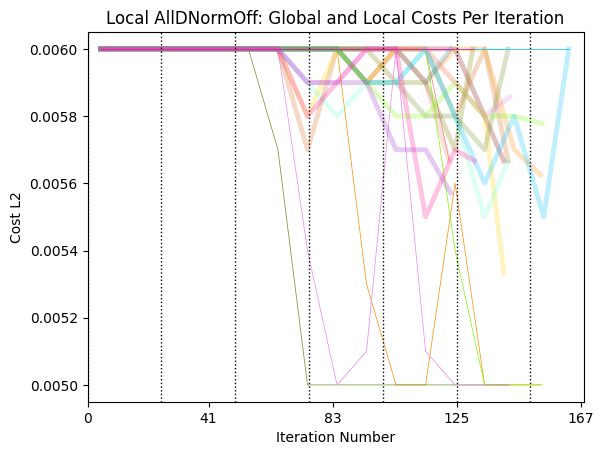

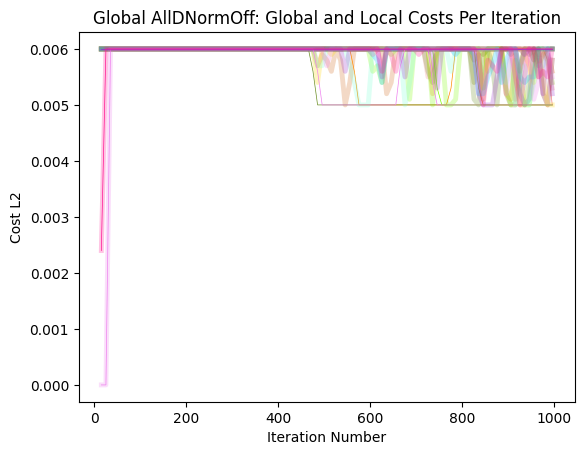

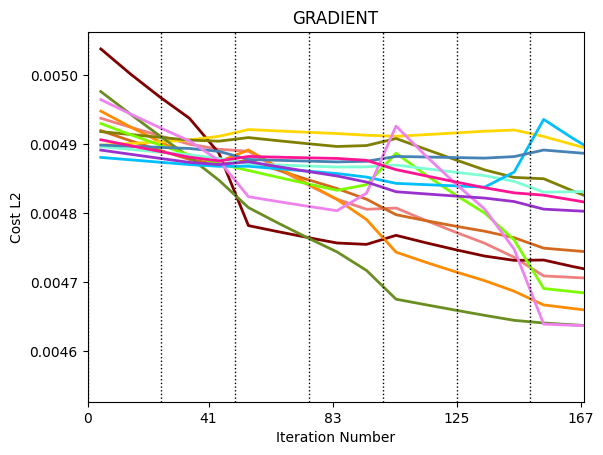

In [8]:
user_c0_1ScipyStep_AllDNormOff = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, normalize_dec=True) for i in range(14)]
global_model_1scipystep_AllDNormOff = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_AllDNormOff, normalize_dec=True)

for i in range(big_loop_iters):
    global_model_1scipystep_AllDNormOff.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_AllDNormOff, 'local', custom_title='Local AllDNormOff: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_1scipystep_AllDNormOff, 'global', show_update_change=False, custom_title='Global AllDNormOff: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep_AllDNormOff, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

In [ ]:
assert(1==0)

# Varying PCA_comps
## Default: 7

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 287, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 681, 100)



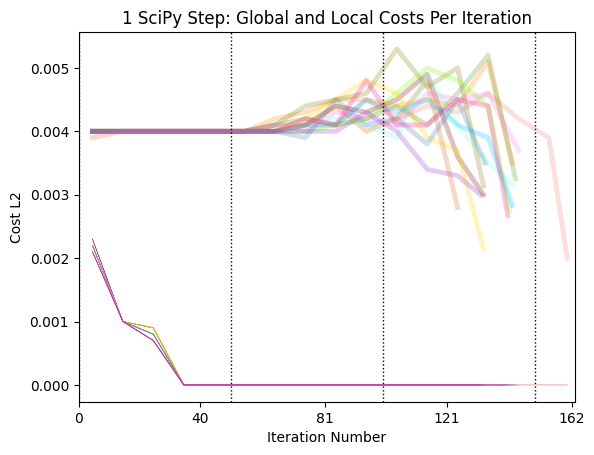

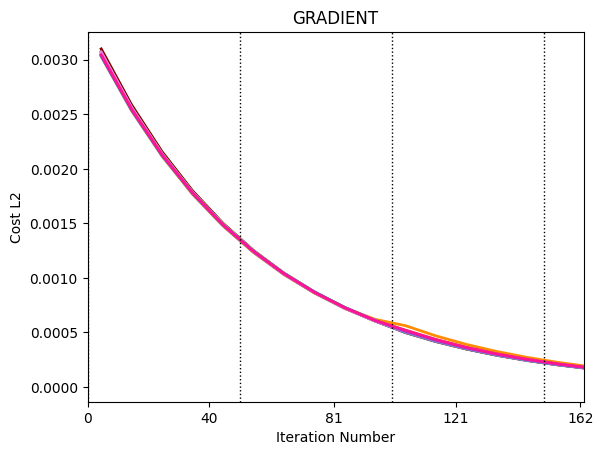

In [17]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## PCA_comps=10

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 365, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 681, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 997, 150)



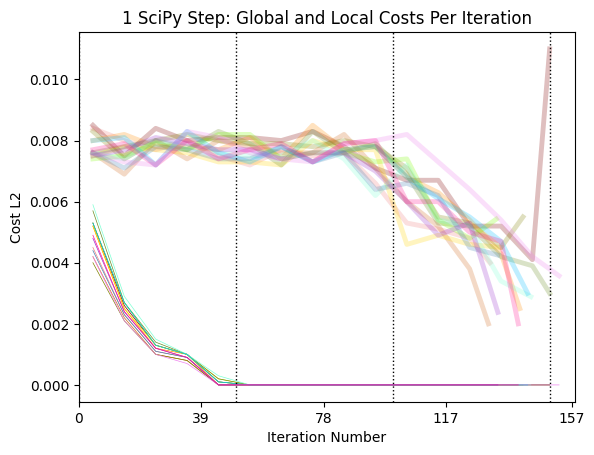

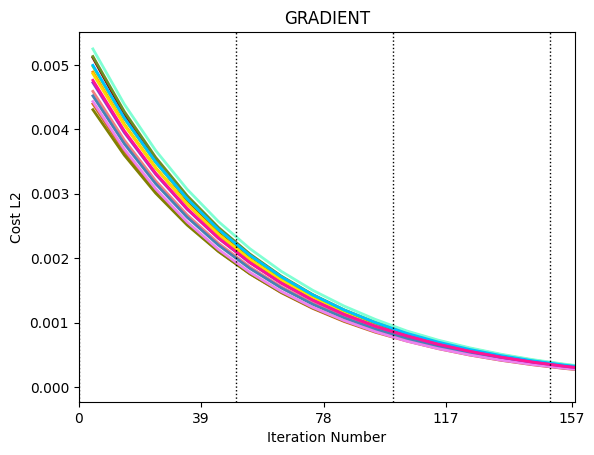

In [18]:
my_PCAs = 10

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, PCA_comps=my_PCAs, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, PCA_comps=my_PCAs)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## PCA_comps=12

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 317, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 595, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 972, 150)



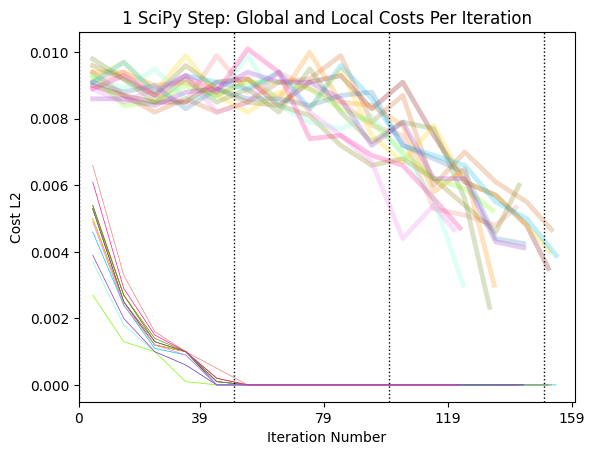

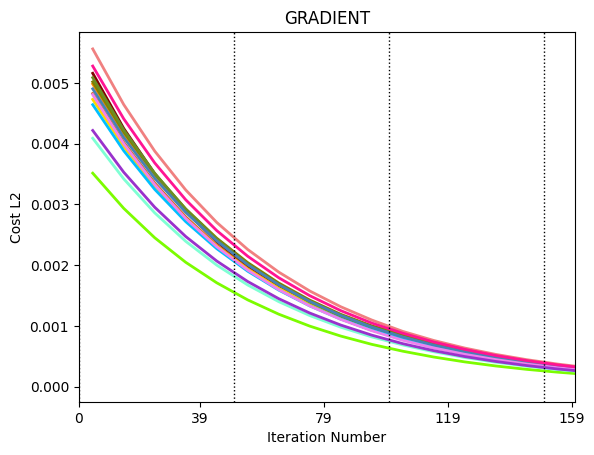

In [19]:
my_PCAs = 12

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, PCA_comps=my_PCAs, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, PCA_comps=my_PCAs)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## PCA_comps=5

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 380, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 691, 100)



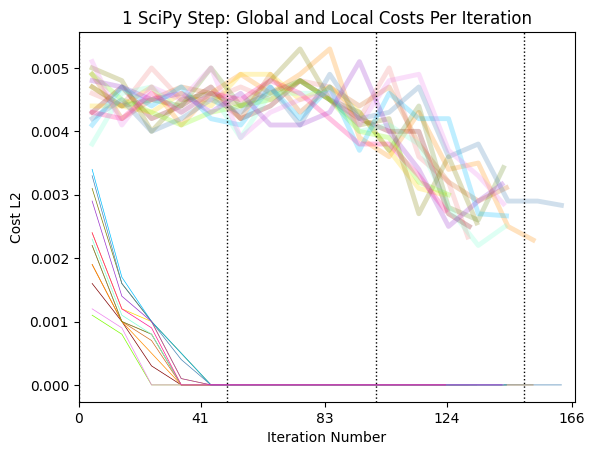

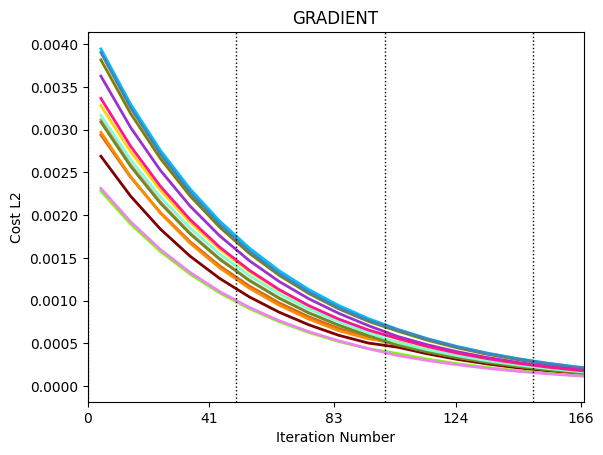

In [20]:
my_PCAs = 5

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, PCA_comps=my_PCAs, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, PCA_comps=my_PCAs)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## PCA_comps=3

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 363, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 694, 100)



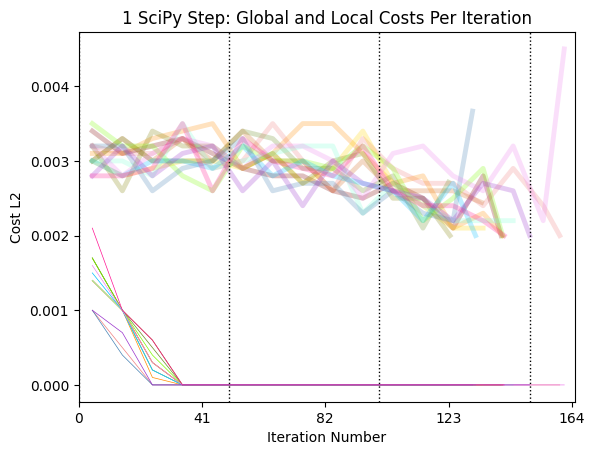

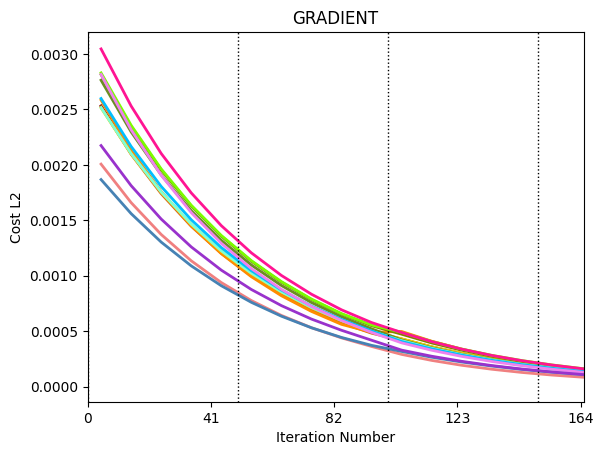

In [21]:
my_PCAs = 3

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, PCA_comps=my_PCAs, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, PCA_comps=my_PCAs)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## PCA_comps=1

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 374, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 767, 100)



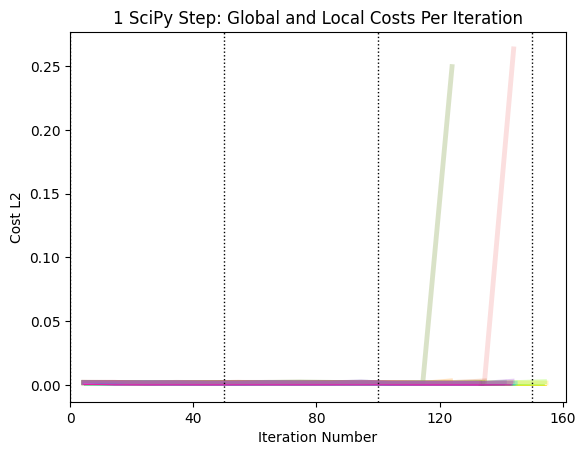

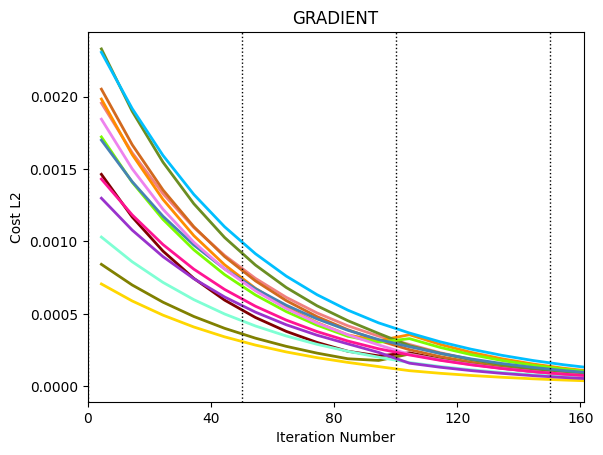

In [23]:
my_PCAs = 1

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, PCA_comps=my_PCAs, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, PCA_comps=my_PCAs)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

In [22]:
assert(1==0)

AssertionError: 

# Varying C (frac of clients used per round)
## Default: 0.1

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 230, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 585, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 967, 150)



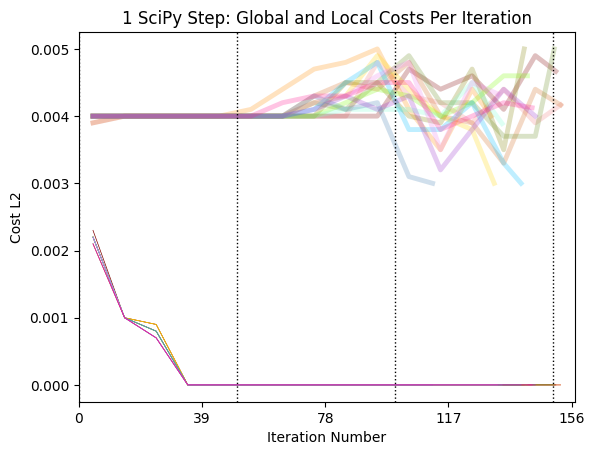

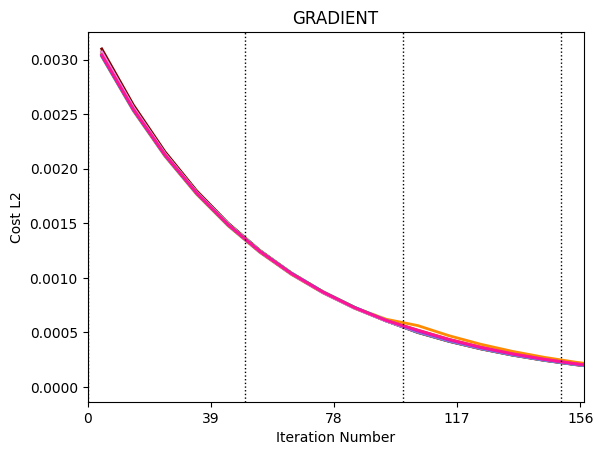

In [11]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## C=0.25

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 169, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 353, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 520, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 689, 200)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 880, 250)



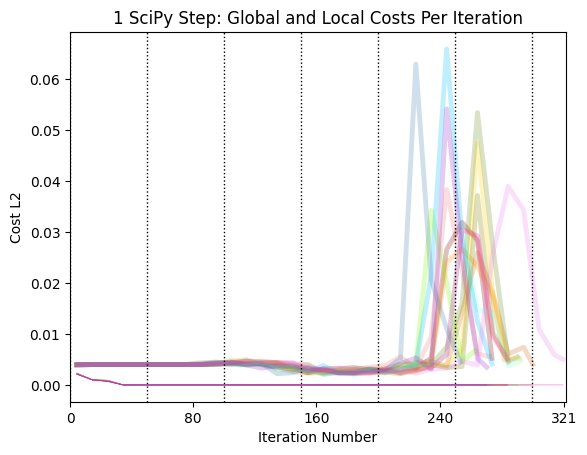

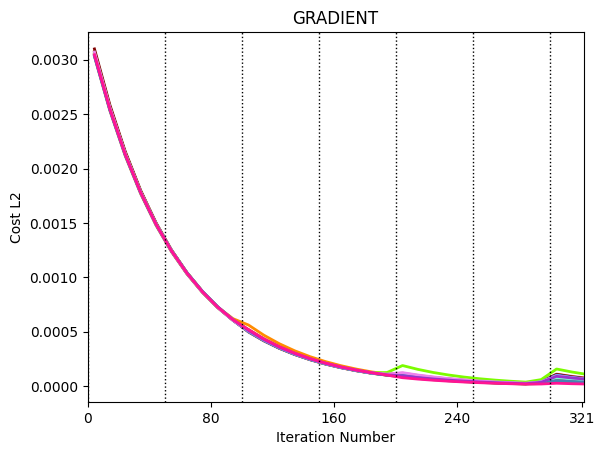

In [12]:
my_C = 0.25

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, C=my_C)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## C=0.5

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 106, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 203, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 313, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 418, 200)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 526, 250)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 608, 300)



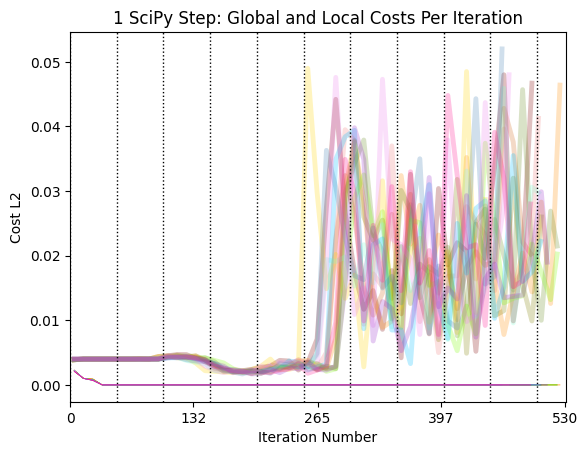

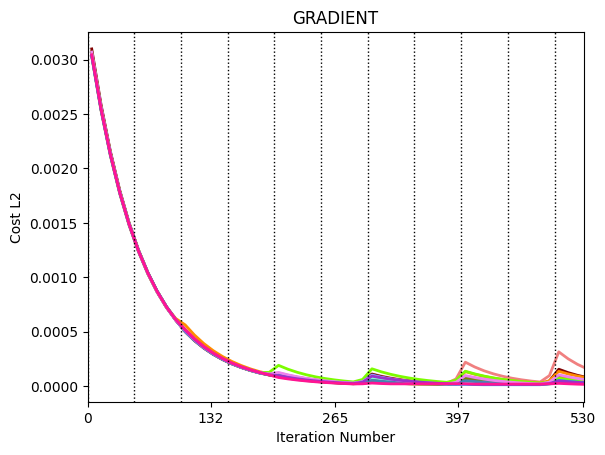

In [13]:
my_C = 0.5

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, C=my_C)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## C=0.75

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 63, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 128, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 198, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 259, 200)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 325, 250)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 393, 300)



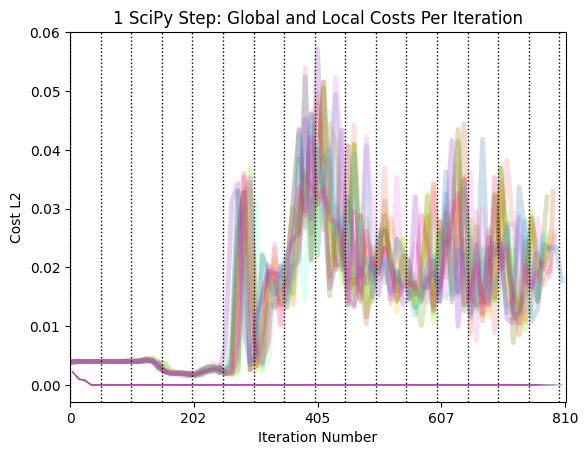

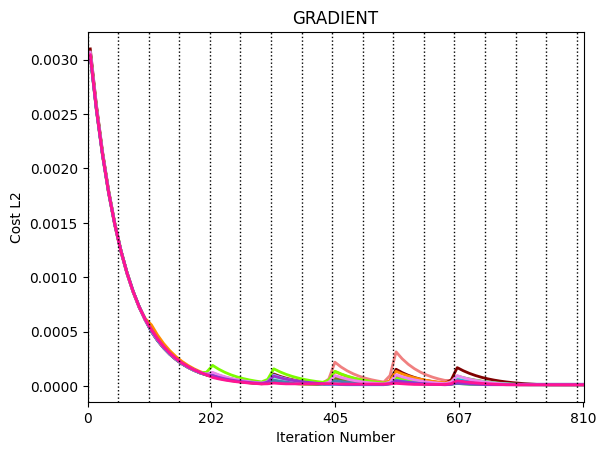

In [14]:
my_C = 0.75

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, C=my_C)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## C=1

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 50, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 100, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 150, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 200, 200)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 250, 250)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 300, 300)



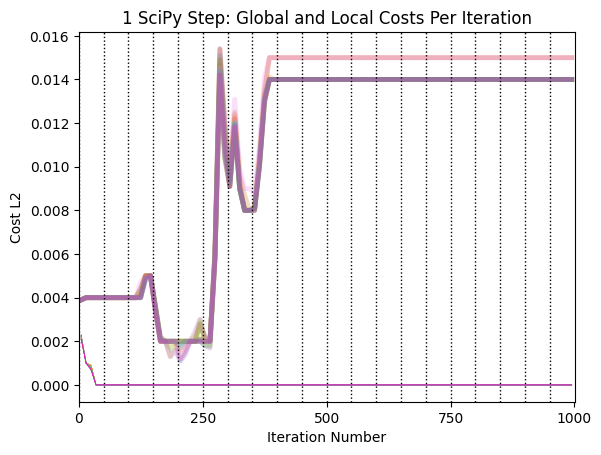

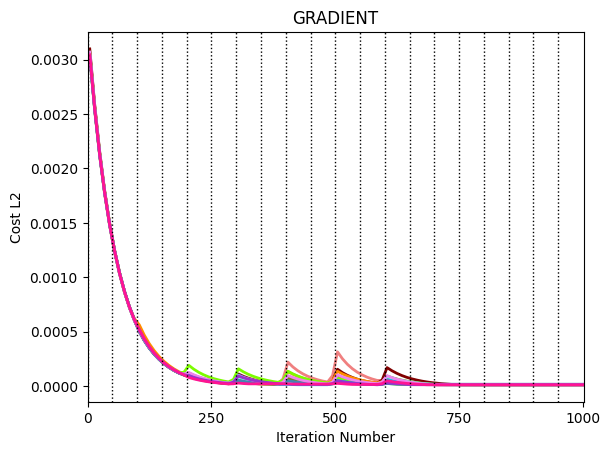

In [15]:
my_C = 1

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep, C=my_C)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

In [16]:
assert(1==0)

AssertionError: 

# Varying local_round_thresh
## Default: 50

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 392, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 815, 100)

(Current Local Round, Current Local Update)
(172, 13)
(119, 12)
(136, 12)
(147, 12)
(133, 12)
(143, 12)
(152, 13)
(140, 12)
(136, 12)
(153, 13)
(137, 12)
(125, 12)
(155, 13)
(152, 13)


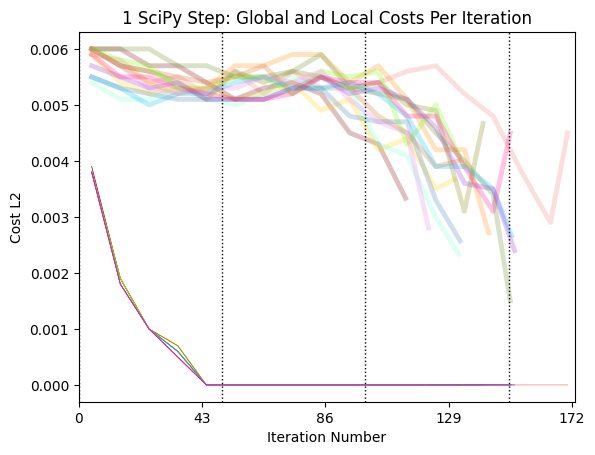

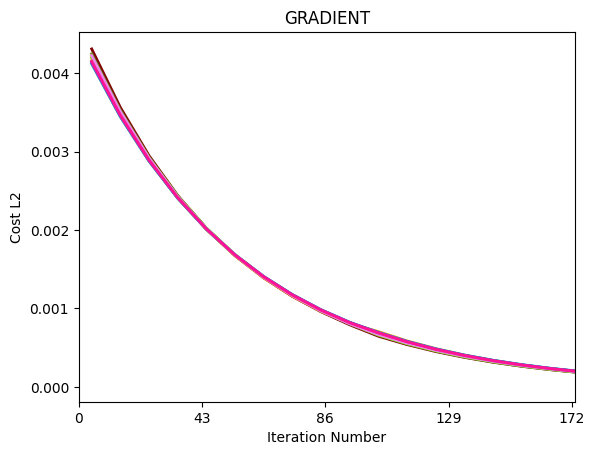

In [5]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

## local_round_thresh=25

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 199, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 320, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 505, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 690, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 842, 125)

(Current Local Round, Current Local Update)
(153, 16)
(148, 15)
(136, 15)
(148, 15)
(131, 15)
(138, 15)
(136, 15)
(141, 15)
(163, 16)
(138, 15)
(137, 15)
(163, 16)
(143, 15)
(125, 15)


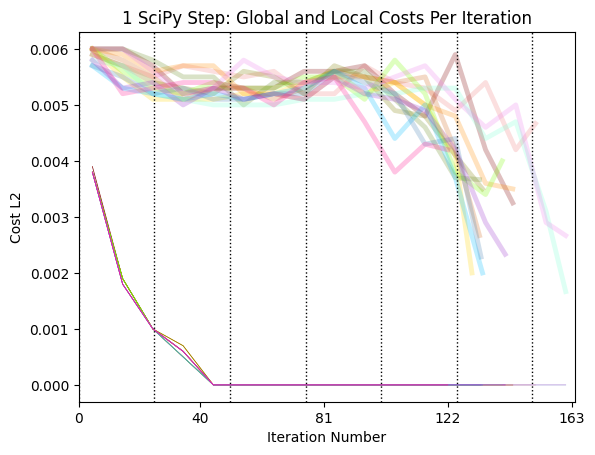

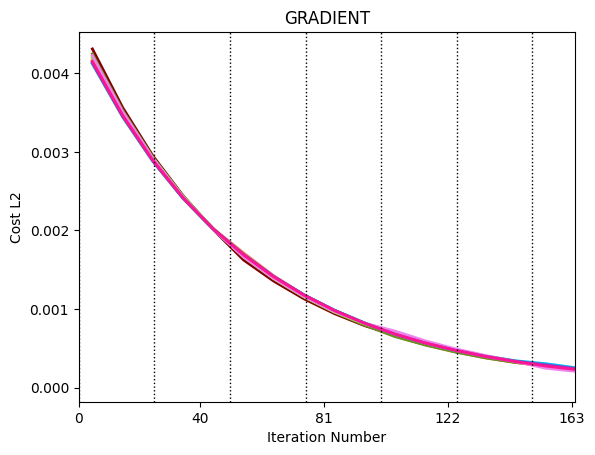

In [6]:
reduced_limit = 25

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## local_round_thresh=10

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 61, 10)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 151, 20)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 220, 30)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 301, 40)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 363, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 459, 60)

(Current Local Round, Current Local Update)
(147, 16)
(135, 16)
(168, 16)
(147, 16)
(139, 16)
(142, 16)
(121, 16)
(111, 16)
(132, 16)
(147, 16)
(148, 16)
(146, 16)
(167, 16)
(150, 16)


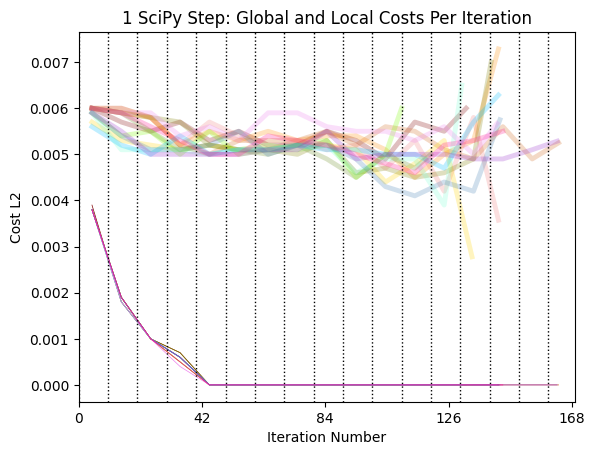

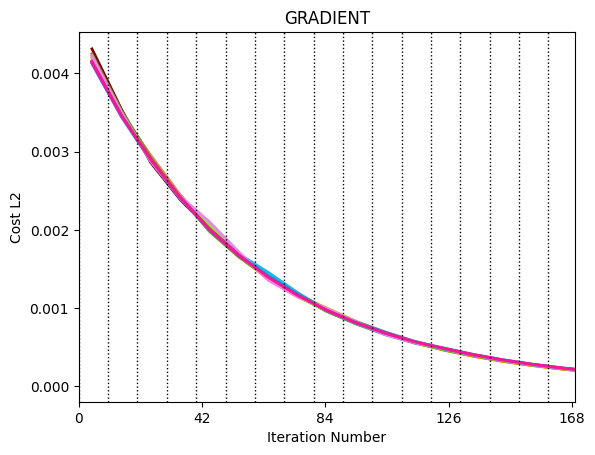

In [7]:
reduced_limit = 10

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## local_round_thresh=1
> This imply after 6 (?) iterations it has reached the last update and trains there for good.  I think it starts on update 10 and the idx goes to 16 (so techincally batch 17, the last batch before the bad batch)

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 2, 1)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 5, 2)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 15, 3)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 16, 4)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 19, 5)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 26, 6)

(Current Local Round, Current Local Update)
(140, 16)
(140, 16)
(155, 16)
(147, 16)
(127, 16)
(150, 16)
(136, 16)
(159, 16)
(167, 16)
(144, 16)
(146, 16)
(151, 16)
(112, 16)
(126, 16)


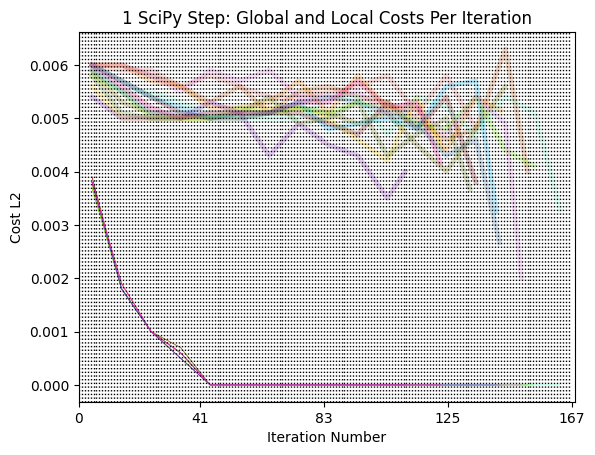

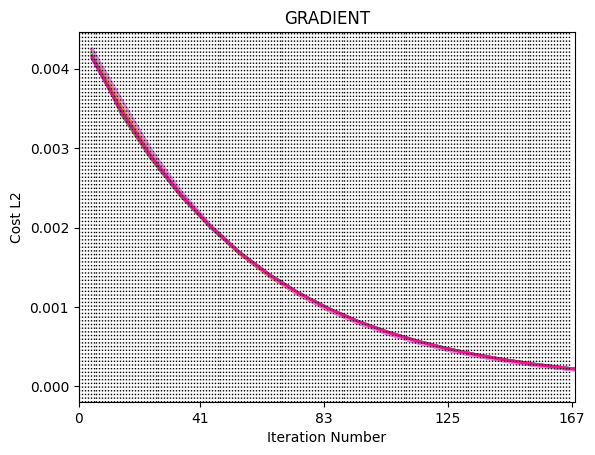

In [8]:
reduced_limit = 1

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## local_round_thresh=100

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 713, 100)

(Current Local Round, Current Local Update)
(152, 11)
(139, 11)
(123, 11)
(136, 11)
(145, 11)
(158, 11)
(147, 11)
(128, 11)
(144, 11)
(141, 11)
(154, 11)
(157, 11)
(140, 11)
(136, 11)


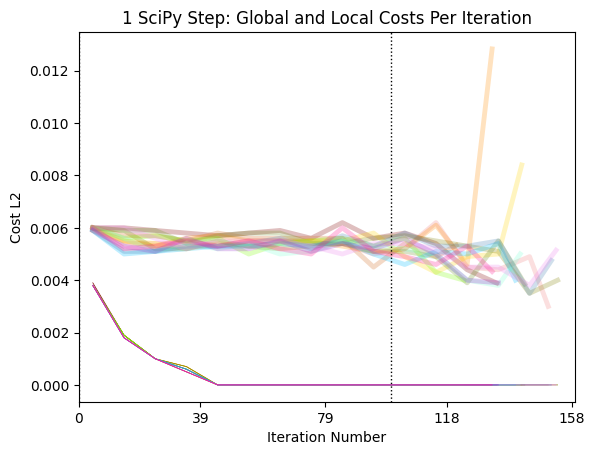

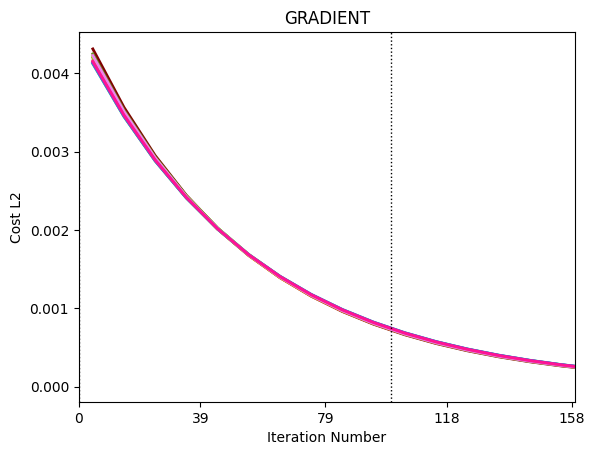

In [9]:
reduced_limit = 100

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

In [ ]:
assert(1==0)

<hr>

# Increasing the number of scipy steps per iter
## 50 Scipy Steps

(137, 12)
(145, 12)
(141, 12)
(146, 12)
(139, 12)
(139, 12)
(151, 13)
(135, 12)
(151, 13)
(131, 12)
(143, 12)
(137, 12)
(159, 13)
(146, 12)


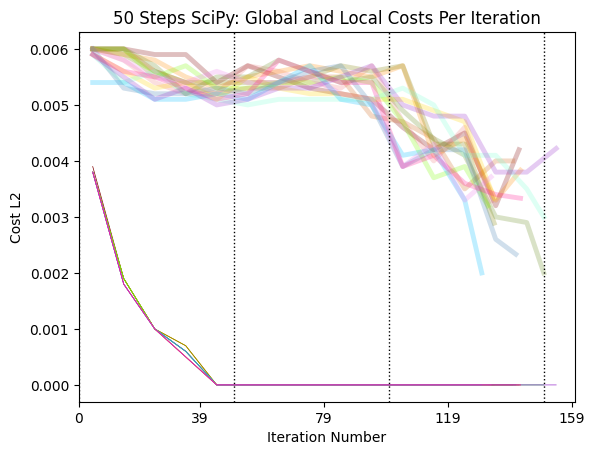

In [10]:
my_steps = 50

user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=my_steps, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
for my_client in global_model_10scipy.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_10scipy, 'local', custom_title=f'{my_steps} Steps SciPy: Global and Local Costs Per Iteration')

## 100 Scipy Steps

(144, 12)
(139, 12)
(143, 12)
(140, 12)
(123, 12)
(156, 13)
(154, 13)
(139, 12)
(137, 12)
(150, 13)
(145, 12)
(131, 12)
(150, 13)
(149, 12)


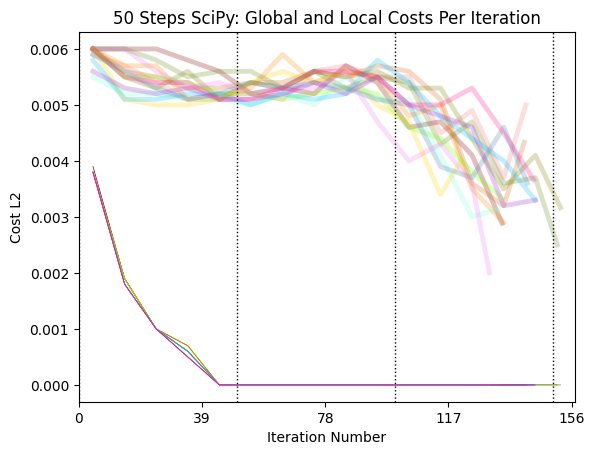

In [11]:
my_steps = 100

user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=my_steps, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
for my_client in global_model_10scipy.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_10scipy, 'local', custom_title=f'{my_steps} Steps SciPy: Global and Local Costs Per Iteration')